In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

[DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

# Setup for training

In [2]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
Number_Channel = 1

# Size of z latent vector (i.e. size of generator input)
Z_dim = 128

# Size of feature maps in generator
Number_Feature_Gen = 64

# Size of feature maps in discriminator
Number_Feature_Dis = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Device
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Data processing

In [3]:
dataset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                                     transform=torchvision.transforms.Compose([
                                         torchvision.transforms.Resize(image_size),
                                         torchvision.transforms.CenterCrop(image_size),
                                         torchvision.transforms.ToTensor(),
                                         torchvision.transforms.Normalize((0.5,), (0.5,)),
                                     ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


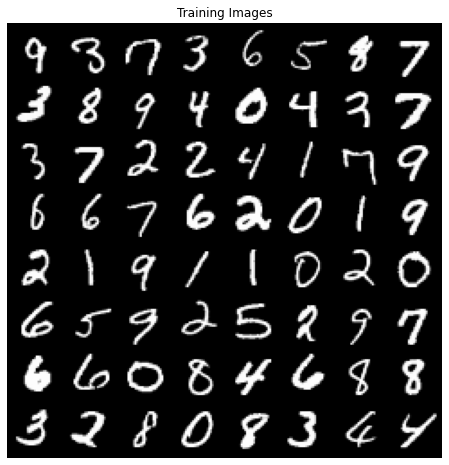

In [4]:
# Plot in 8*8 to show we have the right image

real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

# GAN-Class

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z
            nn.ConvTranspose2d(Z_dim, Number_Feature_Gen * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(Number_Feature_Gen * 4),
            nn.ReLU(True),
            # (Number_Feature_Gen*8) x 4 x 4
            nn.ConvTranspose2d(Number_Feature_Gen * 4, Number_Feature_Gen * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(Number_Feature_Gen * 2),
            nn.ReLU(True),
            # (Number_Feature_Gen*4) x 8 x 8
            nn.ConvTranspose2d(Number_Feature_Gen * 2, Number_Feature_Gen, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Number_Feature_Gen),
            nn.ReLU(True),
            # (Number_Feature_Gen*2) x 16 x 16
            nn.ConvTranspose2d(Number_Feature_Gen, Number_Channel, 4, 2, 1, bias=False),
            # 1 * 28 * 28
            nn.Tanh()
        )
    
    def forward(self, input):
        return self.main(input)
    

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (Number_Channel) x 28 x 28
            nn.Conv2d(Number_Channel, Number_Feature_Dis, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis) x 14 x 14
            nn.Conv2d(Number_Feature_Dis, Number_Feature_Dis * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Number_Feature_Dis * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis*2) x 7 x 7
            nn.Conv2d(Number_Feature_Dis * 2, Number_Feature_Dis * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(Number_Feature_Dis * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis*4) x 4 x 4
            nn.Conv2d(Number_Feature_Dis * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Gan - Create

In [8]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [9]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


# Model parameters

In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, Z_dim, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training

In [11]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, Z_dim, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.5216	Loss_G: 1.4530	D(x): 0.4962	D(G(z)): 0.5039 / 0.2715
[0/5][50/469]	Loss_D: 0.1474	Loss_G: 5.0137	D(x): 0.9549	D(G(z)): 0.0848 / 0.0102
[0/5][100/469]	Loss_D: 0.1205	Loss_G: 4.3082	D(x): 0.9307	D(G(z)): 0.0382 / 0.0219
[0/5][150/469]	Loss_D: 2.3854	Loss_G: 4.5506	D(x): 0.9977	D(G(z)): 0.8672 / 0.0191
[0/5][200/469]	Loss_D: 0.2870	Loss_G: 2.8800	D(x): 0.9281	D(G(z)): 0.1762 / 0.0751
[0/5][250/469]	Loss_D: 0.2605	Loss_G: 3.0305	D(x): 0.8829	D(G(z)): 0.1169 / 0.0571
[0/5][300/469]	Loss_D: 2.8867	Loss_G: 0.0278	D(x): 0.1116	D(G(z)): 0.0006 / 0.9730
[0/5][350/469]	Loss_D: 0.1521	Loss_G: 3.2178	D(x): 0.9206	D(G(z)): 0.0629 / 0.0509
[0/5][400/469]	Loss_D: 0.0889	Loss_G: 3.6271	D(x): 0.9577	D(G(z)): 0.0438 / 0.0333
[0/5][450/469]	Loss_D: 0.1349	Loss_G: 3.2576	D(x): 0.9389	D(G(z)): 0.0661 / 0.0483
[1/5][0/469]	Loss_D: 0.1020	Loss_G: 3.6103	D(x): 0.9389	D(G(z)): 0.0365 / 0.0347
[1/5][50/469]	Loss_D: 0.0880	Loss_G: 3.3471	D(x): 0.9432	D(G(z)): 

# Feedback - Loss while training

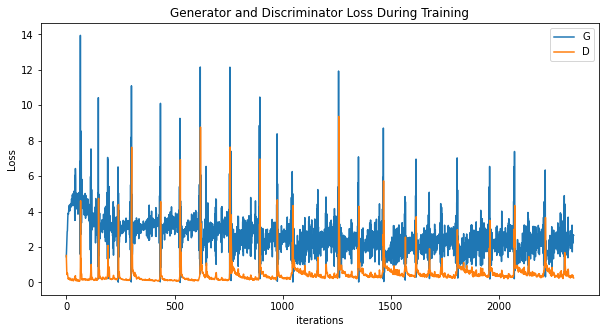

In [12]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Feedback - Animation of image Generated during training

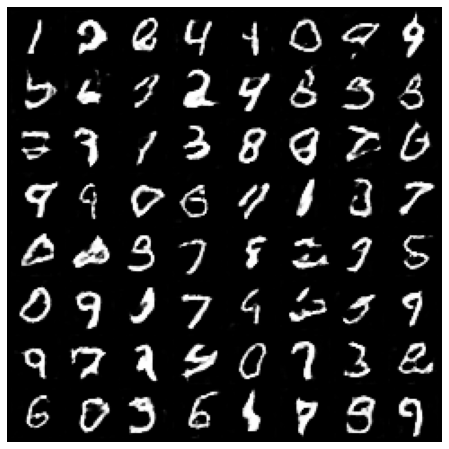

In [13]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Feedback - Real vs. Fake

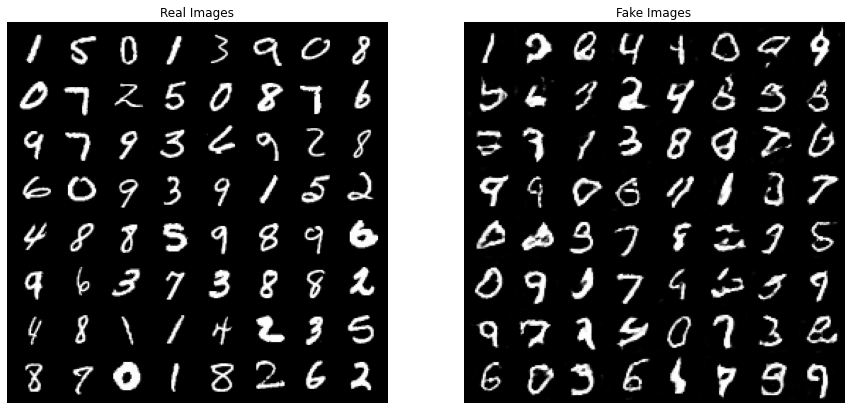

In [14]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()